# Contact Graph Generator

In [1]:
import logging
from large_gcs.graph_generators.contact_graph_generator import (
    ContactGraphGeneratorParams,
    ContactGraphGenerator,
)
from large_gcs.graph.incremental_contact_graph import IncrementalContactGraph
from large_gcs.graph.contact_graph import ContactGraph
from large_gcs.algorithms.search_algorithm import ReexploreLevel
from large_gcs.algorithms.gcs_astar import GcsAstar
from large_gcs.algorithms.gcs_astar_convex_restriction import GcsAstarConvexRestriction
from large_gcs.graph.contact_cost_constraint_factory import (
    contact_shortcut_edge_cost_factory_under,
    contact_shortcut_edge_cost_factory_over_obj_weighted,
)
from large_gcs.cost_estimators.shortcut_edge_ce import ShortcutEdgeCE
from large_gcs.contact.contact_regions_set import ContactRegionParams

import numpy as np
from copy import deepcopy
from IPython.display import HTML
from matplotlib import pyplot as plt


np.set_printoptions(formatter={"float": lambda x: "{0:0.3f}".format(x)})
logging.basicConfig(level=logging.INFO)
# logging.getLogger("large_gcs").setLevel(logging.INFO)
logging.getLogger("drake").setLevel(logging.WARNING)

# Simple Demo

## Simple Demo 2

Set parameter Username
Academic license - for non-commercial use only - expires 2024-04-01


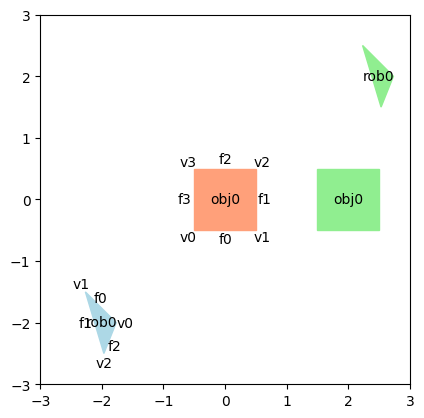

In [2]:
ws = 3
params = ContactGraphGeneratorParams(
    name="cg_simple_2",
    obs_vertices=[],
    obj_vertices=[np.array([[0, 0], [1, 0], [1, 1], [0, 1]]) + np.array([2.5, 0.5])],
    rob_vertices=[np.array([[-1, -1], [-1.5, -0.5], [-1.2, -1.5]])],
    source_obj_pos=[[0, 0]],
    source_rob_pos=[[-2, -2]],
    target_obj_pos=[[2, 0]],
    target_rob_pos=[[2.5, 2]],
    n_pos_per_set=2,
    workspace=[[-ws, ws], [-ws, ws]],
)
generator = ContactGraphGenerator(params)
generator.plot()

In [3]:
generator.generate()

INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 1 body pairs...
100%|██████████| 1/1 [00:00<00:00, 42.35it/s]
INFO:large_gcs.graph.contact_graph:Generating contact sets for 11 sets...
100%|██████████| 11/11 [00:00<00:00, 480.21it/s]
INFO:large_gcs.graph.contact_graph:Pruning empty sets...
100%|██████████| 11/11 [00:00<00:00, 2786.24it/s]
INFO:large_gcs.graph.contact_graph:11 sets remain after removing 0 empty sets
INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 13/13 [00:00<00:00, 5247.93it/s]
INFO:large_gcs.graph.graph:Adding 13 vertices to graph...
100%|██████████| 13/13 [00:00<00:00, 7664.60it/s]
INFO:large_gcs.graph.contact_graph:Generating edges...(parallel)
100%|██████████| 78/78 [00:00<00:00, 12358.09it/s]
INFO:large_gcs.graph.contact_graph:52 edges generated
INFO:large_gcs.graph.contact_graph:Creating edge costs...
100%|██████████| 52/52 [00:00<00:00, 7650.89it/s]
INFO:large_gcs.graph.contact_graph:Creating edge constraints...
1

In [4]:
cg = ContactGraph.load_from_file(params.graph_file_path)

INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 1 body pairs...
100%|██████████| 1/1 [00:00<00:00, 42.13it/s]
INFO:large_gcs.graph.contact_graph:Loading 11 contact pair modes for 2 bodies...
INFO:large_gcs.graph.contact_graph:Generating contact sets for 11 sets...
100%|██████████| 11/11 [00:00<00:00, 511.57it/s]
INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 13/13 [00:00<00:00, 8531.68it/s]
INFO:large_gcs.graph.graph:Adding 13 vertices to graph...
100%|██████████| 13/13 [00:00<00:00, 16498.02it/s]
INFO:large_gcs.graph.contact_graph:Creating edge costs...
100%|██████████| 52/52 [00:00<00:00, 8180.32it/s]
INFO:large_gcs.graph.contact_graph:Creating edge constraints...
100%|██████████| 52/52 [00:00<00:00, 3646.31it/s]
INFO:large_gcs.graph.graph:Adding 52 edges to graph...
100%|██████████| 52/52 [00:00<00:00, 2450.66it/s]
INFO:large_gcs.graph.contact_graph:Created contact graph: GraphParams(dim_bounds=(4, 16), n_vertices=13, n_edges=52, so

In [5]:
generator.generate_incremental_contact_graph()

INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 2/2 [00:00<00:00, 17623.13it/s]
INFO:large_gcs.graph.graph:Adding 2 vertices to graph...
100%|██████████| 2/2 [00:00<00:00, 9177.91it/s]
INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 1 body pairs...
100%|██████████| 1/1 [00:00<00:00, 38.79it/s]
INFO:large_gcs.graph.incremental_contact_graph:Calculating adjacent contact pair modes (55)
100%|██████████| 55/55 [00:00<00:00, 6679.60it/s]


In [6]:
cg_inc = IncrementalContactGraph.load_from_file(params.inc_graph_file_path)

INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 2/2 [00:00<00:00, 23237.14it/s]
INFO:large_gcs.graph.graph:Adding 2 vertices to graph...
100%|██████████| 2/2 [00:00<00:00, 8811.56it/s]
INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 1 body pairs...
100%|██████████| 1/1 [00:00<00:00, 45.93it/s]
INFO:large_gcs.graph.incremental_contact_graph:Calculating adjacent contact pair modes (55)
100%|██████████| 55/55 [00:00<00:00, 4108.62it/s]


### Testing solution methods

In [7]:
cost_estimator = ShortcutEdgeCE(
    cg, shortcut_edge_cost_factory=contact_shortcut_edge_cost_factory_over_obj_weighted
)
gcs_astar = GcsAstarConvexRestriction(
    cg,
    cost_estimator=cost_estimator,
    reexplore_level=ReexploreLevel.FULL,
)
sol = gcs_astar.run()

INFO:large_gcs.algorithms.gcs_astar_convex_restriction:Running GcsAstarConvexRestriction, reexplore_level: ReexploreLevel.FULL
INFO:large_gcs.algorithms.gcs_astar_convex_restriction:
n_vertices_visited: 2, n_edges_visited: 0, n_vertices_explored: 0, vertex_coverage: 0.154, edge_coverage: 0, time_wall_clock: 0, n_gcs_solves: 0, gcs_solve_time_total: 0, gcs_solve_time_iter_mean: 0, gcs_solve_time_last_10_mean: 0, gcs_solve_time_iter_std: 0, gcs_solve_time_iter_min: inf, gcs_solve_time_iter_max: 0, n_vertices_revisited: 0, n_vertices_reexplored: 0
now exploring node source's 2 neighbors (0)
INFO:large_gcs.algorithms.gcs_astar_convex_restriction:
n_vertices_visited: 3, n_edges_visited: 1, n_vertices_explored: 2, vertex_coverage: 0.231, edge_coverage: 0.0192, time_wall_clock: 0.0229, n_gcs_solves: 2, gcs_solve_time_total: 0.00159, gcs_solve_time_iter_mean: 0.000797, gcs_solve_time_last_10_mean: 0, gcs_solve_time_iter_std: 7.87e-05, gcs_solve_time_iter_min: 0.000718, gcs_solve_time_iter_max:

In [ ]:
cost_estimator = ShortcutEdgeCE(
    cg, shortcut_edge_cost_factory=contact_shortcut_edge_cost_factory_under
)
gcs_astar = GcsAstar(
    cg,
    cost_estimator=cost_estimator,
    use_convex_relaxation=False,
)
sol = gcs_astar.run()

In [ ]:
sol = cg.solve_shortest_path(use_convex_relaxation=False)
print(sol)

In [ ]:
sol = cg.solve_shortest_path(use_convex_relaxation=True)
print(sol)

## Simple Demo 3 (Target Region)

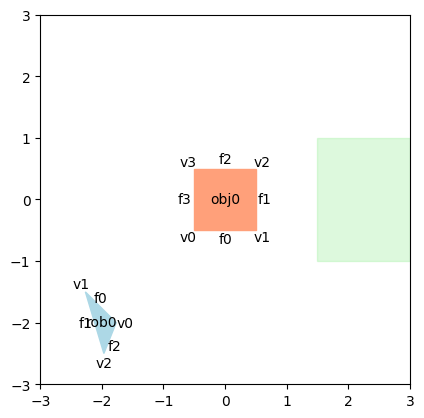

In [8]:
ws = 3
target_regions = [
    ContactRegionParams(
        region_vertices=[[1.5, -1], [1.5, 1], [3, 1], [3, -1]], obj_indices=[0]
    ),
]

params = ContactGraphGeneratorParams(
    name="cg_simple_3",
    obs_vertices=[],
    obj_vertices=[np.array([[0, 0], [1, 0], [1, 1], [0, 1]]) + np.array([2.5, 0.5])],
    rob_vertices=[np.array([[-1, -1], [-1.5, -0.5], [-1.2, -1.5]])],
    source_obj_pos=[[0, 0]],
    source_rob_pos=[[-2, -2]],
    target_region_params=target_regions,
    n_pos_per_set=2,
    workspace=[[-ws, ws], [-ws, ws]],
)
generator = ContactGraphGenerator(params)
generator.plot()

In [9]:
generator.generate()

INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 1 body pairs...
100%|██████████| 1/1 [00:00<00:00, 33.48it/s]
INFO:large_gcs.graph.contact_graph:Generating contact sets for 11 sets...
100%|██████████| 11/11 [00:00<00:00, 322.43it/s]
INFO:large_gcs.graph.contact_graph:Pruning empty sets...
100%|██████████| 11/11 [00:00<00:00, 3223.23it/s]
INFO:large_gcs.graph.contact_graph:11 sets remain after removing 0 empty sets
INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 13/13 [00:00<00:00, 6173.68it/s]
INFO:large_gcs.graph.graph:Adding 13 vertices to graph...
100%|██████████| 13/13 [00:00<00:00, 8216.69it/s]
INFO:large_gcs.graph.contact_graph:Generating edges...(parallel)
100%|██████████| 78/78 [00:00<00:00, 7395.35it/s]
INFO:large_gcs.graph.contact_graph:72 edges generated
INFO:large_gcs.graph.contact_graph:Creating edge costs...
100%|██████████| 72/72 [00:00<00:00, 6410.99it/s]
INFO:large_gcs.graph.contact_graph:Creating edge constraints...
10

In [10]:
generator.generate_incremental_contact_graph()

INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 2/2 [00:00<00:00, 26546.23it/s]
INFO:large_gcs.graph.graph:Adding 2 vertices to graph...
100%|██████████| 2/2 [00:00<00:00, 15592.21it/s]
INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 1 body pairs...
100%|██████████| 1/1 [00:00<00:00, 37.91it/s]
INFO:large_gcs.graph.incremental_contact_graph:Calculating adjacent contact pair modes (55)
100%|██████████| 55/55 [00:00<00:00, 26081.03it/s]


In [11]:
cg_inc = IncrementalContactGraph.load_from_file(params.inc_graph_file_path)

INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 2/2 [00:00<00:00, 11229.73it/s]
INFO:large_gcs.graph.graph:Adding 2 vertices to graph...
100%|██████████| 2/2 [00:00<00:00, 11667.05it/s]
INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 1 body pairs...
100%|██████████| 1/1 [00:00<00:00, 39.32it/s]
INFO:large_gcs.graph.incremental_contact_graph:Calculating adjacent contact pair modes (55)
100%|██████████| 55/55 [00:00<00:00, 5561.40it/s]


# Triangle Challenge

## Triangle Challenge 2

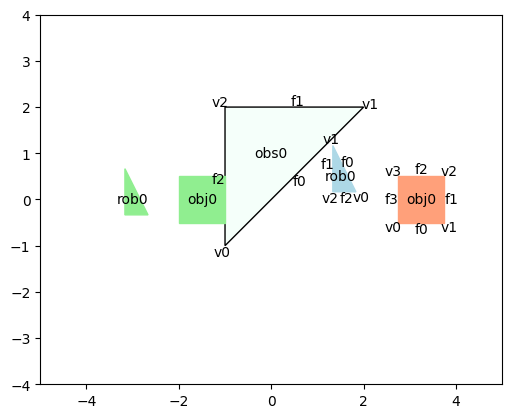

In [16]:
ws_x = 5
ws_y = 4
params = ContactGraphGeneratorParams(
    name="cg_trichal2",
    obs_vertices=[[[-1, 2], [-1, -1], [2, 2]]],
    obj_vertices=[[[1, 0.5], [1, -0.5], [2, -0.5], [2, 0.5]]],
    rob_vertices=[[[3, 1], [3, 0], [3.5, 0]]],
    source_obj_pos=[[3.25, 0]],
    source_rob_pos=[[1.5, 0.5]],
    target_obj_pos=[[-1.5, 0]],
    target_rob_pos=[[-3, 0]],
    n_pos_per_set=2,
    workspace=[[-ws_x, ws_x], [-ws_y, ws_y]],
)

generator = ContactGraphGenerator(params)
generator.plot()

In [17]:
generator.generate()

INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 3 body pairs...
100%|██████████| 3/3 [00:00<00:00, 65.55it/s]
INFO:large_gcs.graph.contact_graph:Generating contact sets for 216 sets...
100%|██████████| 216/216 [00:00<00:00, 445.61it/s]
INFO:large_gcs.graph.contact_graph:Pruning empty sets...
100%|██████████| 216/216 [00:00<00:00, 3661.28it/s]
INFO:large_gcs.graph.contact_graph:179 sets remain after removing 37 empty sets
INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 181/181 [00:00<00:00, 11193.55it/s]
INFO:large_gcs.graph.graph:Adding 181 vertices to graph...
100%|██████████| 181/181 [00:00<00:00, 12086.75it/s]
INFO:large_gcs.graph.contact_graph:Generating edges...(parallel)
100%|██████████| 16290/16290 [00:02<00:00, 7004.02it/s]
INFO:large_gcs.graph.contact_graph:6120 edges generated
INFO:large_gcs.graph.contact_graph:Creating edge costs...
100%|██████████| 6120/6120 [00:00<00:00, 6651.01it/s]
INFO:large_gcs.graph.contact_graph:Creat

In [18]:
cg = ContactGraph.load_from_file(params.graph_file_path)

INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 3 body pairs...
100%|██████████| 3/3 [00:00<00:00, 77.80it/s]
INFO:large_gcs.graph.contact_graph:Loading 20 contact pair modes for 3 bodies...


INFO:large_gcs.graph.contact_graph:Generating contact sets for 179 sets...
100%|██████████| 179/179 [00:00<00:00, 476.81it/s]
INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 181/181 [00:00<00:00, 10332.06it/s]
INFO:large_gcs.graph.graph:Adding 181 vertices to graph...
100%|██████████| 181/181 [00:00<00:00, 9769.38it/s]
INFO:large_gcs.graph.contact_graph:Creating edge costs...
100%|██████████| 6120/6120 [00:00<00:00, 7086.66it/s]
INFO:large_gcs.graph.contact_graph:Creating edge constraints...
100%|██████████| 6120/6120 [00:01<00:00, 4830.69it/s]
INFO:large_gcs.graph.graph:Adding 6120 edges to graph...
100%|██████████| 6120/6120 [00:01<00:00, 5029.56it/s]
INFO:large_gcs.graph.contact_graph:Created contact graph: GraphParams(dim_bounds=(4, 18), n_vertices=181, n_edges=6120, source=[array([3.250, 0.000]), array([1.500, 0.500])], target=[array([-1.500, 0.000]), array([-3,  0])], workspace=array([[-5,  5],
       [-4,  4]]), default_costs_constraints=None)


In [19]:
generator.generate_incremental_contact_graph()
cg_inc = IncrementalContactGraph.load_from_file(params.inc_graph_file_path)

INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 2/2 [00:00<00:00, 12446.01it/s]
INFO:large_gcs.graph.graph:Adding 2 vertices to graph...
100%|██████████| 2/2 [00:00<00:00, 5507.95it/s]
INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 3 body pairs...
100%|██████████| 3/3 [00:00<00:00, 70.62it/s]
INFO:large_gcs.graph.incremental_contact_graph:Calculating adjacent contact pair modes (67)
100%|██████████| 67/67 [00:00<00:00, 6708.00it/s]
INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 2/2 [00:00<00:00, 35394.97it/s]
INFO:large_gcs.graph.graph:Adding 2 vertices to graph...
100%|██████████| 2/2 [00:00<00:00, 9177.91it/s]
INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 3 body pairs...
100%|██████████| 3/3 [00:00<00:00, 74.79it/s]
INFO:large_gcs.graph.incremental_contact_graph:Calculating adjacent contact pair modes (67)
100%|██████████| 67/67 [00:00<00:00, 8442.29it/s]


### Testing solution methods

In [15]:
logging.getLogger("large_gcs.algorithms.gcs_astar_convex_restriction").setLevel(
    logging.DEBUG
)
cost_estimator = ShortcutEdgeCE(
    cg, shortcut_edge_cost_factory=contact_shortcut_edge_cost_factory_over_obj_weighted
)
gcs_astar = GcsAstarConvexRestriction(
    cg,
    cost_estimator=cost_estimator,
    reexplore_level=ReexploreLevel.NONE,
)
sol = gcs_astar.run()

INFO:large_gcs.algorithms.gcs_astar_convex_restriction:Running GcsAstarConvexRestriction, reexplore_level: ReexploreLevel.NONE
INFO:large_gcs.algorithms.gcs_astar_convex_restriction:visited_fd_vertices: {'source', 'target'}
INFO:large_gcs.algorithms.gcs_astar_convex_restriction:
n_vertices_visited: 2, n_edges_visited: 0, n_vertices_explored: 0, vertex_coverage: 0.011, edge_coverage: 0, time_wall_clock: 0, n_gcs_solves: 0, gcs_solve_time_total: 0, gcs_solve_time_iter_mean: 0, gcs_solve_time_last_10_mean: 0, gcs_solve_time_iter_std: 0, gcs_solve_time_iter_min: inf, gcs_solve_time_iter_max: 0, n_vertices_revisited: 0, n_vertices_reexplored: 0
now exploring node source's 1 neighbors (0)
DEBUG:large_gcs.algorithms.gcs_astar_convex_restriction:edge source -> ('NC|obs0_f0-obj0_v3', 'NC|obs0_f0-rob0_v1', 'NC|obj0_f3-rob0_v0') is feasible, new dist: 238.26001654659783, added to pq True
INFO:large_gcs.algorithms.gcs_astar_convex_restriction:visited_fd_vertices: {'source', "('NC|obs0_f0-obj0_v3',

In [ ]:
anim = cg.animate_solution()
HTML(anim.to_html5_video())

## Triangle Challenge 3

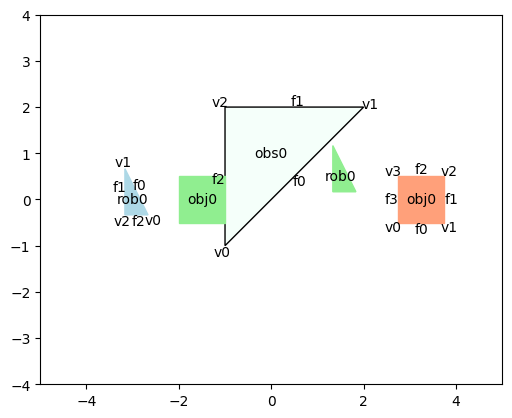

In [14]:
ws_x = 5
ws_y = 4
params = ContactGraphGeneratorParams(
    name="cg_trichal3",
    obs_vertices=[[[-1, 2], [-1, -1], [2, 2]]],
    obj_vertices=[[[1, 0.5], [1, -0.5], [2, -0.5], [2, 0.5]]],
    rob_vertices=[[[3, 1], [3, 0], [3.5, 0]]],
    source_obj_pos=[[3.25, 0]],
    source_rob_pos=[[-3, 0]],
    target_obj_pos=[[-1.5, 0]],
    target_rob_pos=[[1.5, 0.5]],
    n_pos_per_set=2,
    workspace=[[-ws_x, ws_x], [-ws_y, ws_y]],
)

generator = ContactGraphGenerator(params)
generator.plot()

In [15]:
generator.generate()

INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 3 body pairs...
100%|██████████| 3/3 [00:00<00:00, 61.50it/s]
INFO:large_gcs.graph.contact_graph:Generating contact sets for 216 sets...
100%|██████████| 216/216 [00:04<00:00, 47.13it/s]
INFO:large_gcs.graph.contact_graph:Pruning empty sets...
100%|██████████| 216/216 [00:00<00:00, 3896.61it/s]
INFO:large_gcs.graph.contact_graph:179 sets remain after removing 37 empty sets
INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 181/181 [00:00<00:00, 8314.83it/s]
INFO:large_gcs.graph.graph:Adding 181 vertices to graph...
100%|██████████| 181/181 [00:00<00:00, 10678.38it/s]
INFO:large_gcs.graph.contact_graph:Generating edges...(parallel)
  0%|          | 10/16290 [00:03<1:02:43,  4.33it/s]

Set parameter Username
Set parameter Username
Set parameter Username
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-04
Academic license - for non-commercial use only - expires 2024-03-04
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-04
Academic license - for non-commercial use only - expires 2024-03-04
Set parameter Username
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-04
Academic license - for non-commercial use only - expires 2024-03-04
Academic license - for non-commercial use only - expires 2024-03-04
Set parameter Username
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-04
Academic license - for non-commercial use only - expires 2024-03-04
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-04
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-04

100%|██████████| 16290/16290 [00:04<00:00, 3499.24it/s] 
INFO:large_gcs.graph.contact_graph:6120 edges generated
INFO:large_gcs.graph.contact_graph:Creating edge costs...
100%|██████████| 6120/6120 [00:00<00:00, 8167.36it/s]
INFO:large_gcs.graph.contact_graph:Creating edge constraints...
100%|██████████| 6120/6120 [00:01<00:00, 4578.96it/s]
INFO:large_gcs.graph.graph:Adding 6120 edges to graph...
100%|██████████| 6120/6120 [00:01<00:00, 4101.30it/s]
INFO:large_gcs.graph.contact_graph:Created contact graph: GraphParams(dim_bounds=(4, 18), n_vertices=181, n_edges=6120, source=[array([3.250, 0.000]), array([-3,  0])], target=[array([-1.500, 0.000]), array([1.500, 0.500])], workspace=array([[-5,  5],
       [-4,  4]]), default_costs_constraints=None)


In [16]:
generator.generate_incremental_contact_graph()
cg_inc = IncrementalContactGraph.load_from_file(params.inc_graph_file_path)

INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 2/2 [00:00<00:00, 41734.37it/s]
INFO:large_gcs.graph.graph:Adding 2 vertices to graph...
100%|██████████| 2/2 [00:00<00:00, 17697.49it/s]
INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 3 body pairs...
100%|██████████| 3/3 [00:00<00:00, 58.42it/s]
INFO:large_gcs.graph.incremental_contact_graph:Calculating adjacent contact pair modes (67)
100%|██████████| 67/67 [00:03<00:00, 20.34it/s]

Set parameter Username
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-04
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-04
Academic license - for non-commercial use only - expires 2024-03-04
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-04
Set parameter Username
Set parameter Username
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-04
Academic license - for non-commercial use only - expires 2024-03-04
Academic license - for non-commercial use only - expires 2024-03-04
Set parameter Username
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-04
Academic license - for non-commercial use only - expires 2024-03-04
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-04
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-04


INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 2/2 [00:00<00:00, 28630.06it/s]
INFO:large_gcs.graph.graph:Adding 2 vertices to graph...
100%|██████████| 2/2 [00:00<00:00, 15505.74it/s]
INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 3 body pairs...
100%|██████████| 3/3 [00:00<00:00, 54.36it/s]
INFO:large_gcs.graph.incremental_contact_graph:Calculating adjacent contact pair modes (67)
100%|██████████| 67/67 [00:03<00:00, 18.54it/s]

Set parameter Username
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-04
Set parameter Username
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-04
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-04
Academic license - for non-commercial use only - expires 2024-03-04
Academic license - for non-commercial use only - expires 2024-03-04
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-04
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-04
Set parameter Username
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-04
Academic license - for non-commercial use only - expires 2024-03-04
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-04
Set parameter Username
Set parameter Username
Academic license - for non-commercial use on

In [17]:
cg = ContactGraph.load_from_file(params.graph_file_path)

INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 3 body pairs...
100%|██████████| 3/3 [00:00<00:00, 65.90it/s]
INFO:large_gcs.graph.contact_graph:Loading 20 contact pair modes for 3 bodies...
INFO:large_gcs.graph.contact_graph:Generating contact sets for 179 sets...
100%|██████████| 179/179 [00:03<00:00, 46.40it/s]
INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 181/181 [00:00<00:00, 9231.93it/s]
INFO:large_gcs.graph.graph:Adding 181 vertices to graph...
100%|██████████| 181/181 [00:00<00:00, 9586.92it/s]
INFO:large_gcs.graph.contact_graph:Creating edge costs...
100%|██████████| 6120/6120 [00:00<00:00, 8313.60it/s]
INFO:large_gcs.graph.contact_graph:Creating edge constraints...
100%|██████████| 6120/6120 [00:01<00:00, 4272.01it/s]
INFO:large_gcs.graph.graph:Adding 6120 edges to graph...
100%|██████████| 6120/6120 [00:01<00:00, 3607.70it/s]
INFO:large_gcs.graph.contact_graph:Created contact graph: GraphParams(dim_bounds=(4, 18), n_vertice

In [24]:
generator.generate_incremental_contact_graph()
cg_inc = IncrementalContactGraph.load_from_file(params.inc_graph_file_path)

INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 2/2 [00:00<00:00, 12965.39it/s]
INFO:large_gcs.graph.graph:Adding 2 vertices to graph...
100%|██████████| 2/2 [00:00<00:00, 9372.75it/s]
INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 3 body pairs...
100%|██████████| 3/3 [00:00<00:00, 61.39it/s]
INFO:large_gcs.graph.incremental_contact_graph:Calculating adjacent contact pair modes (67)
100%|██████████| 67/67 [00:00<00:00, 12777.63it/s]
INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 2/2 [00:00<00:00, 32388.45it/s]
INFO:large_gcs.graph.graph:Adding 2 vertices to graph...
100%|██████████| 2/2 [00:00<00:00, 21732.15it/s]
INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 3 body pairs...
100%|██████████| 3/3 [00:00<00:00, 70.51it/s]
INFO:large_gcs.graph.incremental_contact_graph:Calculating adjacent contact pair modes (67)
100%|██████████| 67/67 [00:00<00:00, 5868.00it/s]


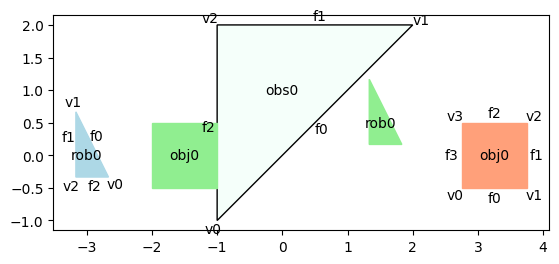

In [18]:
cg_inc.plot()

## Triangle Challenge 4 (Target Region)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-04-01


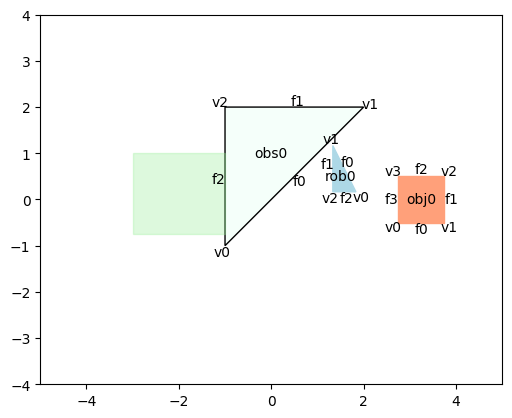

In [2]:
ws_x = 5
ws_y = 4
target_region_params = [
    ContactRegionParams(
        region_vertices=[[-3, -0.75], [-3, 1], [-1, -0.75], [-1, 1]], obj_indices=[0]
    ),
]
params = ContactGraphGeneratorParams(
    name="cg_trichal4",
    obs_vertices=[[[-1, 2], [-1, -1], [2, 2]]],
    obj_vertices=[[[1, 0.5], [1, -0.5], [2, -0.5], [2, 0.5]]],
    rob_vertices=[[[3, 1], [3, 0], [3.5, 0]]],
    source_obj_pos=[[3.25, 0]],
    source_rob_pos=[[1.5, 0.5]],
    target_region_params=target_region_params,
    n_pos_per_set=2,
    workspace=[[-ws_x, ws_x], [-ws_y, ws_y]],
)

generator = ContactGraphGenerator(params)
generator.plot()

In [3]:
generator.generate()

INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 3 body pairs...
100%|██████████| 3/3 [00:00<00:00, 61.65it/s]
INFO:large_gcs.graph.contact_graph:Generating contact sets for 216 sets...
100%|██████████| 216/216 [00:00<00:00, 460.45it/s]
INFO:large_gcs.graph.contact_graph:Pruning empty sets...
100%|██████████| 216/216 [00:00<00:00, 3884.45it/s]
INFO:large_gcs.graph.contact_graph:179 sets remain after removing 37 empty sets
INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 181/181 [00:00<00:00, 10436.32it/s]
INFO:large_gcs.graph.graph:Adding 181 vertices to graph...
100%|██████████| 181/181 [00:00<00:00, 13054.91it/s]
INFO:large_gcs.graph.contact_graph:Generating edges...(parallel)
100%|██████████| 16290/16290 [00:02<00:00, 6977.31it/s]
INFO:large_gcs.graph.contact_graph:6145 edges generated
INFO:large_gcs.graph.contact_graph:Creating edge costs...
100%|██████████| 6145/6145 [00:00<00:00, 9251.84it/s]
INFO:large_gcs.graph.contact_graph:Creat

In [4]:
generator.generate_incremental_contact_graph()
cg_inc = IncrementalContactGraph.load_from_file(params.inc_graph_file_path)

INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 2/2 [00:00<00:00, 34521.02it/s]
INFO:large_gcs.graph.graph:Adding 2 vertices to graph...
100%|██████████| 2/2 [00:00<00:00, 15947.92it/s]
INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 3 body pairs...
100%|██████████| 3/3 [00:00<00:00, 67.52it/s]


INFO:large_gcs.graph.incremental_contact_graph:Calculating adjacent contact pair modes (67)
100%|██████████| 67/67 [00:00<00:00, 5812.41it/s]
INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 2/2 [00:00<00:00, 15420.24it/s]
INFO:large_gcs.graph.graph:Adding 2 vertices to graph...
100%|██████████| 2/2 [00:00<00:00, 18396.07it/s]
INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 3 body pairs...
100%|██████████| 3/3 [00:00<00:00, 68.53it/s]
INFO:large_gcs.graph.incremental_contact_graph:Calculating adjacent contact pair modes (67)
100%|██████████| 67/67 [00:00<00:00, 7629.73it/s]


## Trichal 5-15

In [29]:
seed = 0
ws_x = 5
ws_y = 4
bl = np.array([-ws_x, -ws_y])
tr_width = 1.5
target_region_vertices= np.array([bl, bl + np.array([tr_width, 0]), bl + np.array([tr_width, tr_width]), bl + np.array([0, tr_width])])
generators = []
i = 0
while len(generators) < 10:
    i += 1
    np.random.seed(seed+i)
    target_region_offset = np.random.uniform([0,0], [2*ws_x-tr_width, 2*ws_y-tr_width])
    target_region_params = [
        ContactRegionParams(
            region_vertices=target_region_vertices+target_region_offset, obj_indices=[0]
        ),
    ]
    buffer = 2
    body_offsets = np.random.uniform([-ws_x+buffer, -ws_y+buffer], [ws_x-buffer, ws_y-buffer], size=(2,2))

    params = ContactGraphGeneratorParams(
        name="cg_trichal"+str(len(generators)+5),
        obs_vertices=[[[-1, 2], [-1, -1], [2, 2]]],
        obj_vertices=[[[1, 0.5], [1, -0.5], [2, -0.5], [2, 0.5]]],
        rob_vertices=[[[3, 1], [3, 0], [3.5, 0]]],
        source_obj_pos=[np.zeros(2)+body_offsets[0]],
        source_rob_pos=[np.zeros(2)+body_offsets[1]],
        target_region_params=target_region_params,
        n_pos_per_set=2,
        workspace=[[-ws_x, ws_x], [-ws_y, ws_y]],
    )

    generator = ContactGraphGenerator(params)
    is_valid = generator.is_valid()
    # print(is_valid)
    if is_valid:
        generators.append(generator)
        print(len(generators))
    # generator.plot()
    # plt.show()

1
2
3
4
5
6
7
8
9
10


In [30]:
for i, generator in enumerate(generators):
    # generator.plot()
    # plt.show()
    generator.generate_incremental_contact_graph()


INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 2/2 [00:00<00:00, 46603.38it/s]
INFO:large_gcs.graph.graph:Adding 2 vertices to graph...


100%|██████████| 2/2 [00:00<00:00, 13025.79it/s]
INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 3 body pairs...
100%|██████████| 3/3 [00:00<00:00, 56.67it/s]
INFO:large_gcs.graph.incremental_contact_graph:Calculating adjacent contact pair modes (67)
100%|██████████| 67/67 [00:00<00:00, 766.50it/s]
INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 2/2 [00:00<00:00, 21788.59it/s]
INFO:large_gcs.graph.graph:Adding 2 vertices to graph...
100%|██████████| 2/2 [00:00<00:00, 20763.88it/s]
INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 3 body pairs...
100%|██████████| 3/3 [00:00<00:00, 72.48it/s]
INFO:large_gcs.graph.incremental_contact_graph:Calculating adjacent contact pair modes (67)
100%|██████████| 67/67 [00:00<00:00, 686.54it/s]
INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 2/2 [00:00<00:00, 48210.39it/s]
INFO:large_gcs.graph.graph:Adding 2 vertices to graph...
100%|██████████| 2/2 [00:0

# Maze a

## Maze a1

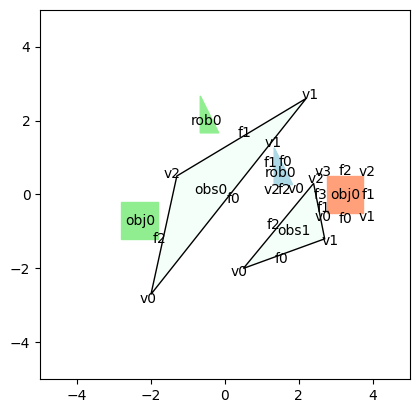

In [12]:
ws_x = 5
ws_y = 5
params = ContactGraphGeneratorParams(
    name="cg_maze_a1",
    obs_vertices=[
        [[-2, -2.7], [2.2, 2.6], [-1.3, 0.5]],
        [[0.5, -2], [2.7, -1.2], [2.4, 0.3]],
    ],
    obj_vertices=[[[1, 0.5], [1, -0.5], [2, -0.5], [2, 0.5]]],
    rob_vertices=[[[3, 1], [3, 0], [3.5, 0]]],
    source_obj_pos=[[3.25, 0]],
    source_rob_pos=[[1.5, 0.6]],
    target_obj_pos=[[-2.3, -0.7]],
    target_rob_pos=[[-0.5, 2]],
    n_pos_per_set=2,
    workspace=[[-ws_x, ws_x], [-ws_y, ws_y]],
)

generator = ContactGraphGenerator(params)
generator.plot()

In [ ]:
generator.generate()

In [ ]:
cg = ContactGraph.load_from_file(params.graph_file_path)

In [13]:
generator.generate_incremental_contact_graph()
cg_inc = IncrementalContactGraph.load_from_file(params.inc_graph_file_path)

INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 2/2 [00:00<00:00, 36954.22it/s]
INFO:large_gcs.graph.graph:Adding 2 vertices to graph...
100%|██████████| 2/2 [00:00<00:00, 15033.35it/s]
INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 5 body pairs...
100%|██████████| 5/5 [00:00<00:00, 59.41it/s]
INFO:large_gcs.graph.incremental_contact_graph:Calculating adjacent contact pair modes (132)
100%|██████████| 132/132 [00:02<00:00, 45.87it/s]

Set parameter Username
Set parameter Username
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-04Academic license - for non-commercial use only - expires 2024-03-04

Academic license - for non-commercial use only - expires 2024-03-04
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-04
Set parameter Username
Set parameter Username
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-04
Academic license - for non-commercial use only - expires 2024-03-04
Academic license - for non-commercial use only - expires 2024-03-04
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-04
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-04
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-04
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-04


INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 2/2 [00:00<00:00, 9950.90it/s]
INFO:large_gcs.graph.graph:Adding 2 vertices to graph...
100%|██████████| 2/2 [00:00<00:00, 18682.87it/s]
INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 5 body pairs...
100%|██████████| 5/5 [00:00<00:00, 62.93it/s]
INFO:large_gcs.graph.incremental_contact_graph:Calculating adjacent contact pair modes (132)
100%|██████████| 132/132 [00:03<00:00, 41.49it/s]

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-04
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-04
Set parameter Username
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-04
Academic license - for non-commercial use only - expires 2024-03-04
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-04
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-04
Set parameter Username
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-04
Academic license - for non-commercial use only - expires 2024-03-04
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-04
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-04
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-04

## Maze a2

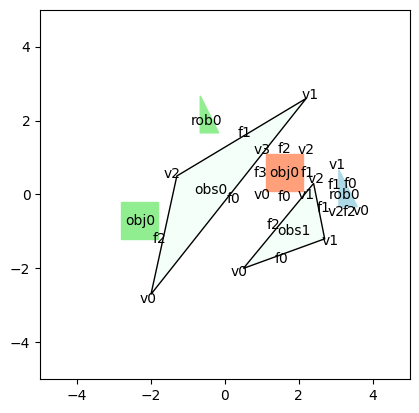

In [2]:
ws_x = 5
ws_y = 5
params = ContactGraphGeneratorParams(
    name="cg_maze_a2",
    obs_vertices=[
        [[-2, -2.7], [2.2, 2.6], [-1.3, 0.5]],
        [[0.5, -2], [2.7, -1.2], [2.4, 0.3]],
    ],
    obj_vertices=[[[1, 0.5], [1, -0.5], [2, -0.5], [2, 0.5]]],
    rob_vertices=[[[3, 1], [3, 0], [3.5, 0]]],
    source_obj_pos=[[1.6, 0.6]],
    source_rob_pos=[[3.25, 0]],
    target_obj_pos=[[-2.3, -0.7]],
    target_rob_pos=[[-0.5, 2]],
    n_pos_per_set=2,
    workspace=[[-ws_x, ws_x], [-ws_y, ws_y]],
)

generator = ContactGraphGenerator(params)
generator.plot()

In [29]:
generator.generate()

INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 5 body pairs...
100%|██████████| 5/5 [00:00<00:00, 61.32it/s]
INFO:large_gcs.graph.contact_graph:Generating contact sets for 8100 sets...
100%|██████████| 8100/8100 [00:21<00:00, 381.74it/s]
INFO:large_gcs.graph.contact_graph:Pruning empty sets...
100%|██████████| 8100/8100 [00:01<00:00, 5865.76it/s]
INFO:large_gcs.graph.contact_graph:836 sets remain after removing 7264 empty sets
INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 838/838 [00:00<00:00, 10864.56it/s]
INFO:large_gcs.graph.graph:Adding 838 vertices to graph...
100%|██████████| 838/838 [00:00<00:00, 12027.48it/s]
INFO:large_gcs.graph.contact_graph:Generating edges...(parallel)
100%|██████████| 350703/350703 [00:48<00:00, 7173.61it/s]
INFO:large_gcs.graph.contact_graph:29994 edges generated
INFO:large_gcs.graph.contact_graph:Creating edge costs...
100%|██████████| 29994/29994 [00:03<00:00, 8771.24it/s]
INFO:large_gcs.graph.contact

In [30]:
cg = ContactGraph.load_from_file(params.graph_file_path)

INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 5 body pairs...
100%|██████████| 5/5 [00:00<00:00, 67.60it/s]
INFO:large_gcs.graph.contact_graph:Loading 35 contact pair modes for 4 bodies...
INFO:large_gcs.graph.contact_graph:Generating contact sets for 836 sets...
100%|██████████| 836/836 [00:02<00:00, 414.74it/s]
INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 838/838 [00:00<00:00, 11124.70it/s]
INFO:large_gcs.graph.graph:Adding 838 vertices to graph...
100%|██████████| 838/838 [00:00<00:00, 10377.68it/s]
INFO:large_gcs.graph.contact_graph:Creating edge costs...
100%|██████████| 29994/29994 [00:03<00:00, 8018.75it/s]
INFO:large_gcs.graph.contact_graph:Creating edge constraints...
100%|██████████| 29994/29994 [00:05<00:00, 5015.83it/s]
INFO:large_gcs.graph.graph:Adding 29994 edges to graph...
100%|██████████| 29994/29994 [00:06<00:00, 4954.37it/s]
INFO:large_gcs.graph.contact_graph:Created contact graph: GraphParams(dim_bounds=(4, 18),

In [3]:
generator.generate_incremental_contact_graph()
cg_inc = IncrementalContactGraph.load_from_file(params.inc_graph_file_path)

INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 2/2 [00:00<00:00, 23172.95it/s]
INFO:large_gcs.graph.graph:Adding 2 vertices to graph...
100%|██████████| 2/2 [00:00<00:00, 12018.06it/s]
INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 5 body pairs...
100%|██████████| 5/5 [00:00<00:00, 69.07it/s]

Searching bodypair ('obs0', 'obj0') source_neighbor contact pair modes
Found source_neighbor contact pair modes NC|obs0_f0-obj0_v3
Searching bodypair ('obs0', 'rob0') source_neighbor contact pair modes
Found source_neighbor contact pair modes NC|obs0_f0-rob0_v1
Searching bodypair ('obs1', 'obj0') source_neighbor contact pair modes
Found source_neighbor contact pair modes NC|obs1_f2-obj0_v1
Searching bodypair ('obs1', 'rob0') source_neighbor contact pair modes
Found source_neighbor contact pair modes NC|obs1_f1-rob0_v2
Searching bodypair ('obj0', 'rob0') source_neighbor contact pair modes
Found source_neighbor contact pair modes NC|obj0_f1-rob0_f1



INFO:large_gcs.graph.incremental_contact_graph:Calculating adjacent contact pair modes (132)
100%|██████████| 132/132 [00:00<00:00, 678.06it/s]


5 _body_pair_to_mode_ids: {('obs0', 'obj0'): ['IC|obs0_f0-obj0_v3', 'IC|obs0_f1-obj0_v1', 'IC|obs0_f2-obj0_v1', 'IC|obs0_v0-obj0_f1', 'IC|obs0_v0-obj0_f2', 'IC|obs0_v1-obj0_f0', 'IC|obs0_v1-obj0_f3', 'NC|obs0_f0-obj0_v3', 'NC|obs0_f1-obj0_v1', 'NC|obs0_f2-obj0_v1'], ('obs0', 'rob0'): ['NC|obs0_f0-rob0_v1', 'NC|obs0_f1-rob0_v0', 'NC|obs0_f2-rob0_v0'], ('obs1', 'obj0'): ['IC|obs1_f0-obj0_v3', 'IC|obs1_f1-obj0_v0', 'IC|obs1_f2-obj0_v1', 'IC|obs1_v0-obj0_f1', 'IC|obs1_v0-obj0_f2', 'IC|obs1_v1-obj0_f3', 'IC|obs1_v2-obj0_f0', 'NC|obs1_f0-obj0_v3', 'NC|obs1_f1-obj0_v0', 'NC|obs1_f2-obj0_v1'], ('obs1', 'rob0'): ['NC|obs1_f0-rob0_v1', 'NC|obs1_f1-rob0_v2', 'NC|obs1_f2-rob0_v0'], ('obj0', 'rob0'): ['IC|obj0_f1-rob0_f1', 'IC|obj0_f2-rob0_f2', 'IC|obj0_f0-rob0_v1', 'IC|obj0_f3-rob0_v0', 'IC|obj0_v0-rob0_f0', 'NC|obj0_f1-rob0_f1', 'NC|obj0_f2-rob0_f2', 'NC|obj0_f0-rob0_v1', 'NC|obj0_f3-rob0_v0']}
('obs0', 'obj0'): ['IC|obs0_f0-obj0_v3', 'IC|obs0_f1-obj0_v1', 'IC|obs0_f2-obj0_v1', 'IC|obs0_v0-obj0_f

INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 2/2 [00:00<00:00, 20068.44it/s]
INFO:large_gcs.graph.graph:Adding 2 vertices to graph...
100%|██████████| 2/2 [00:00<00:00, 7157.52it/s]
INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 5 body pairs...
100%|██████████| 5/5 [00:00<00:00, 65.39it/s]

Searching bodypair ('obs0', 'obj0') source_neighbor contact pair modes
Found source_neighbor contact pair modes NC|obs0_f0-obj0_v3
Searching bodypair ('obs0', 'rob0') source_neighbor contact pair modes
Found source_neighbor contact pair modes NC|obs0_f0-rob0_v1
Searching bodypair ('obs1', 'obj0') source_neighbor contact pair modes
Found source_neighbor contact pair modes NC|obs1_f2-obj0_v1
Searching bodypair ('obs1', 'rob0') source_neighbor contact pair modes
Found source_neighbor contact pair modes NC|obs1_f1-rob0_v2
Searching bodypair ('obj0', 'rob0') source_neighbor contact pair modes
Found source_neighbor contact pair modes NC|obj0_f1-rob0_f1



INFO:large_gcs.graph.incremental_contact_graph:Calculating adjacent contact pair modes (132)
100%|██████████| 132/132 [00:00<00:00, 629.30it/s]

5 _body_pair_to_mode_ids: {('obs0', 'obj0'): ['IC|obs0_f0-obj0_v3', 'IC|obs0_f1-obj0_v1', 'IC|obs0_f2-obj0_v1', 'IC|obs0_v0-obj0_f1', 'IC|obs0_v0-obj0_f2', 'IC|obs0_v1-obj0_f0', 'IC|obs0_v1-obj0_f3', 'NC|obs0_f0-obj0_v3', 'NC|obs0_f1-obj0_v1', 'NC|obs0_f2-obj0_v1'], ('obs0', 'rob0'): ['NC|obs0_f0-rob0_v1', 'NC|obs0_f1-rob0_v0', 'NC|obs0_f2-rob0_v0'], ('obs1', 'obj0'): ['IC|obs1_f0-obj0_v3', 'IC|obs1_f1-obj0_v0', 'IC|obs1_f2-obj0_v1', 'IC|obs1_v0-obj0_f1', 'IC|obs1_v0-obj0_f2', 'IC|obs1_v1-obj0_f3', 'IC|obs1_v2-obj0_f0', 'NC|obs1_f0-obj0_v3', 'NC|obs1_f1-obj0_v0', 'NC|obs1_f2-obj0_v1'], ('obs1', 'rob0'): ['NC|obs1_f0-rob0_v1', 'NC|obs1_f1-rob0_v2', 'NC|obs1_f2-rob0_v0'], ('obj0', 'rob0'): ['IC|obj0_f1-rob0_f1', 'IC|obj0_f2-rob0_f2', 'IC|obj0_f0-rob0_v1', 'IC|obj0_f3-rob0_v0', 'IC|obj0_v0-rob0_f0', 'NC|obj0_f1-rob0_f1', 'NC|obj0_f2-rob0_f2', 'NC|obj0_f0-rob0_v1', 'NC|obj0_f3-rob0_v0']}
('obs0', 'obj0'): ['IC|obs0_f0-obj0_v3', 'IC|obs0_f1-obj0_v1', 'IC|obs0_f2-obj0_v1', 'IC|obs0_v0-obj0_f

## Maze a10-a19

1


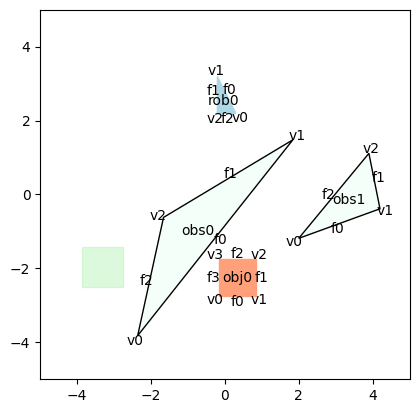

2


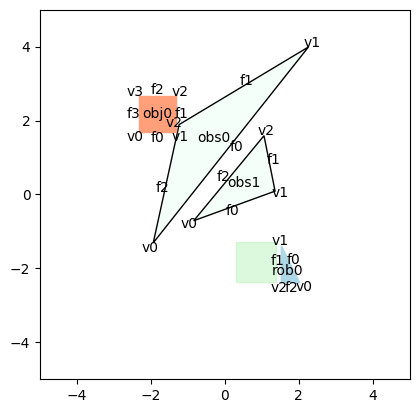

3


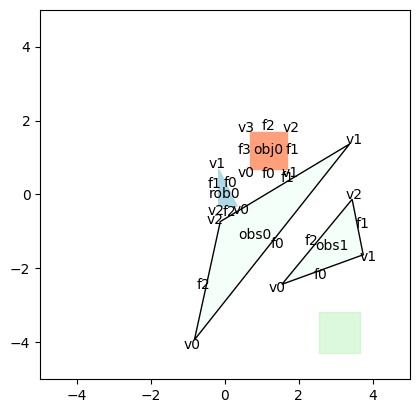

4


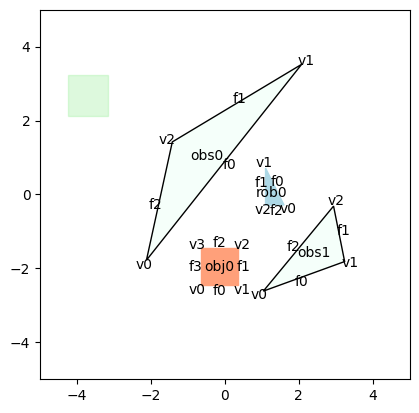

5


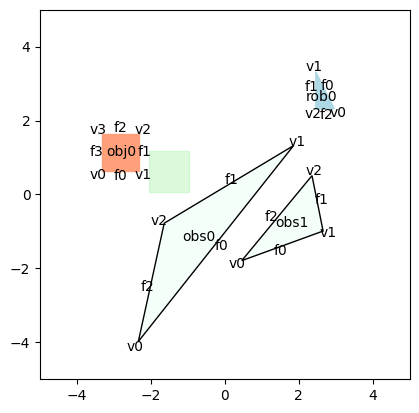

6


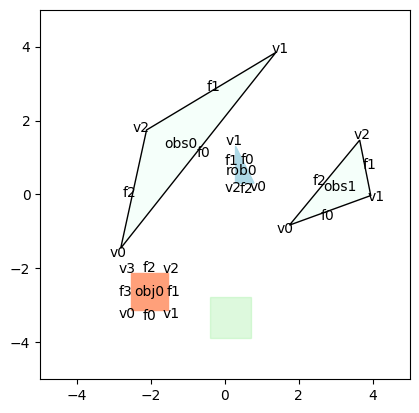

7


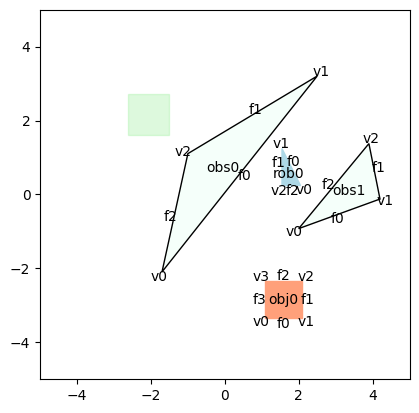

8


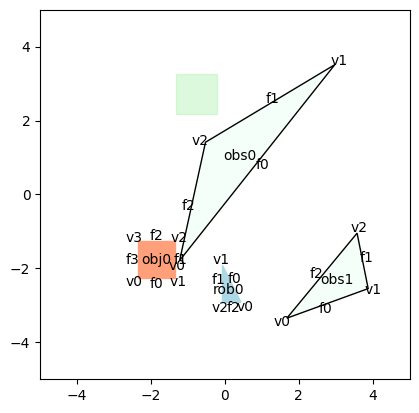

9


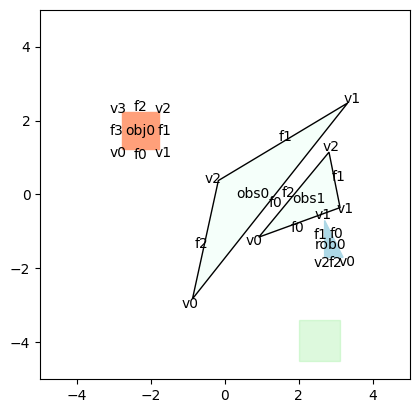

10


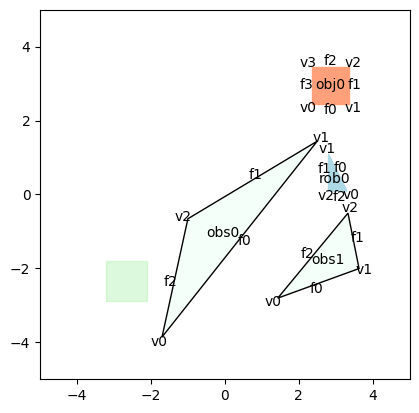

In [2]:
ws_x = 5
ws_y = 5
seed = 123
bl = np.array([-ws_x, -ws_y])
tr_width = 1.1
target_region_vertices= np.array([bl, bl + np.array([tr_width, 0]), bl + np.array([tr_width, tr_width]), bl + np.array([0, tr_width])])
generators = []
i = 0
while len(generators) < 10:
    i += 1
    np.random.seed(seed+i)
    buffer=2
    target_region_offset = np.random.uniform([0,0], [2*ws_x-buffer, 2*ws_y-buffer])
    target_region_params = [
        ContactRegionParams(
            region_vertices=target_region_vertices+target_region_offset, obj_indices=[0]
        ),
    ]
    
    body_offsets = np.random.uniform([-ws_x+buffer, -ws_y+buffer], [ws_x-buffer, ws_y-buffer], size=(2,2))
    obs_offsets = np.random.uniform([-1.5, -1.5], [1.5, 1.5], size=(2,2))
    obs_a_vertices = np.array([[-2, -2.7], [2.2, 2.6], [-1.3, 0.5]]) + obs_offsets[0]
    obs_b_vertices = np.array([[0.5, -2], [2.7, -1.2], [2.4, 0.3]]) + obs_offsets[1]
    params = ContactGraphGeneratorParams(
        name="cg_maze_a"+str(len(generators)+10),
        obs_vertices=[
            obs_a_vertices,
            obs_b_vertices,
        ],
        obj_vertices=[[[1, 0.5], [1, -0.5], [2, -0.5], [2, 0.5]]],
        rob_vertices=[[[3, 1], [3, 0], [3.5, 0]]],
        source_obj_pos=[np.zeros(2)+body_offsets[0]],
        source_rob_pos=[np.zeros(2)+body_offsets[1]],
        target_region_params=target_region_params,
        n_pos_per_set=2,
        workspace=[[-ws_x, ws_x], [-ws_y, ws_y]],
    )

    generator = ContactGraphGenerator(params)
    is_valid = generator.is_valid()
    # print(is_valid)
    if is_valid:
        generators.append(generator)
        print(len(generators))
        generator.plot()
        plt.show()

In [3]:
for i, generator in enumerate(generators):
    # generator.plot()
    # plt.show()
    print(f"Generating {i}")
    generator.generate_incremental_contact_graph()

Generating 0


INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 2/2 [00:00<00:00, 28532.68it/s]
INFO:large_gcs.graph.graph:Adding 2 vertices to graph...
100%|██████████| 2/2 [00:00<00:00, 9000.65it/s]
INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 5 body pairs...
100%|██████████| 5/5 [00:00<00:00, 67.59it/s]
INFO:large_gcs.graph.incremental_contact_graph:Calculating adjacent contact pair modes (257)
100%|██████████| 257/257 [00:00<00:00, 772.70it/s]
INFO:large_gcs.graph.contact_graph:Creating vertex costs...


Generating 1


100%|██████████| 2/2 [00:00<00:00, 22489.57it/s]
INFO:large_gcs.graph.graph:Adding 2 vertices to graph...
100%|██████████| 2/2 [00:00<00:00, 24600.02it/s]
INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 5 body pairs...
100%|██████████| 5/5 [00:00<00:00, 60.03it/s]
INFO:large_gcs.graph.incremental_contact_graph:Calculating adjacent contact pair modes (257)
100%|██████████| 257/257 [00:00<00:00, 797.53it/s]
INFO:large_gcs.graph.contact_graph:Creating vertex costs...


Generating 2


100%|██████████| 2/2 [00:00<00:00, 33825.03it/s]
INFO:large_gcs.graph.graph:Adding 2 vertices to graph...
100%|██████████| 2/2 [00:00<00:00, 14873.42it/s]
INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 5 body pairs...
100%|██████████| 5/5 [00:00<00:00, 65.95it/s]
INFO:large_gcs.graph.incremental_contact_graph:Calculating adjacent contact pair modes (257)
100%|██████████| 257/257 [00:00<00:00, 765.00it/s]
INFO:large_gcs.graph.contact_graph:Creating vertex costs...


Generating 3


100%|██████████| 2/2 [00:00<00:00, 28630.06it/s]
INFO:large_gcs.graph.graph:Adding 2 vertices to graph...
100%|██████████| 2/2 [00:00<00:00, 13464.86it/s]
INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 5 body pairs...
100%|██████████| 5/5 [00:00<00:00, 67.68it/s]
INFO:large_gcs.graph.incremental_contact_graph:Calculating adjacent contact pair modes (257)
100%|██████████| 257/257 [00:00<00:00, 764.11it/s]
INFO:large_gcs.graph.contact_graph:Creating vertex costs...


Generating 4


100%|██████████| 2/2 [00:00<00:00, 12300.01it/s]
INFO:large_gcs.graph.graph:Adding 2 vertices to graph...
100%|██████████| 2/2 [00:00<00:00, 23629.88it/s]
INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 5 body pairs...
100%|██████████| 5/5 [00:00<00:00, 64.24it/s]
INFO:large_gcs.graph.incremental_contact_graph:Calculating adjacent contact pair modes (257)
100%|██████████| 257/257 [00:00<00:00, 759.29it/s]
INFO:large_gcs.graph.contact_graph:Creating vertex costs...


Generating 5


100%|██████████| 2/2 [00:00<00:00, 49344.75it/s]
INFO:large_gcs.graph.graph:Adding 2 vertices to graph...
100%|██████████| 2/2 [00:00<00:00, 25420.02it/s]
INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 5 body pairs...
100%|██████████| 5/5 [00:00<00:00, 61.81it/s]
INFO:large_gcs.graph.incremental_contact_graph:Calculating adjacent contact pair modes (257)
100%|██████████| 257/257 [00:00<00:00, 833.99it/s]
INFO:large_gcs.graph.contact_graph:Creating vertex costs...


Generating 6


100%|██████████| 2/2 [00:00<00:00, 48770.98it/s]
INFO:large_gcs.graph.graph:Adding 2 vertices to graph...
100%|██████████| 2/2 [00:00<00:00, 17225.07it/s]
INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 5 body pairs...
100%|██████████| 5/5 [00:00<00:00, 65.47it/s]
INFO:large_gcs.graph.incremental_contact_graph:Calculating adjacent contact pair modes (257)
100%|██████████| 257/257 [00:00<00:00, 777.03it/s]
INFO:large_gcs.graph.contact_graph:Creating vertex costs...


Generating 7


100%|██████████| 2/2 [00:00<00:00, 14979.66it/s]
INFO:large_gcs.graph.graph:Adding 2 vertices to graph...
100%|██████████| 2/2 [00:00<00:00, 16416.06it/s]
INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 5 body pairs...
100%|██████████| 5/5 [00:00<00:00, 57.26it/s]
INFO:large_gcs.graph.incremental_contact_graph:Calculating adjacent contact pair modes (257)
100%|██████████| 257/257 [00:00<00:00, 796.73it/s]
INFO:large_gcs.graph.contact_graph:Creating vertex costs...


Generating 8


100%|██████████| 2/2 [00:00<00:00, 12052.60it/s]
INFO:large_gcs.graph.graph:Adding 2 vertices to graph...
100%|██████████| 2/2 [00:00<00:00, 13706.88it/s]
INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 5 body pairs...
100%|██████████| 5/5 [00:00<00:00, 67.42it/s]
INFO:large_gcs.graph.incremental_contact_graph:Calculating adjacent contact pair modes (257)
100%|██████████| 257/257 [00:00<00:00, 828.48it/s]
INFO:large_gcs.graph.contact_graph:Creating vertex costs...


Generating 9


100%|██████████| 2/2 [00:00<00:00, 27324.46it/s]
INFO:large_gcs.graph.graph:Adding 2 vertices to graph...
100%|██████████| 2/2 [00:00<00:00, 13315.25it/s]
INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 5 body pairs...
100%|██████████| 5/5 [00:00<00:00, 63.59it/s]
INFO:large_gcs.graph.incremental_contact_graph:Calculating adjacent contact pair modes (257)
100%|██████████| 257/257 [00:00<00:00, 709.24it/s]


In [9]:
base = "cg_maze_a"
names = [base+str(i) for i in range(10, 20)]
# print without quotes:
print(*names, sep=", ")


cg_maze_a10, cg_maze_a11, cg_maze_a12, cg_maze_a13, cg_maze_a14, cg_maze_a15, cg_maze_a16, cg_maze_a17, cg_maze_a18, cg_maze_a19


# StackPush

## StackPush a1 (2 objects)

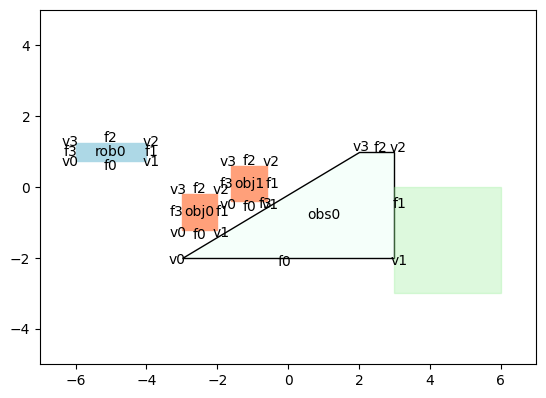

In [4]:
ws_x = 7
ws_y = 5
target_region_params = [
    ContactRegionParams(
        region_vertices=[[3, 0], [3, -3], [6, 0], [6, -3]], obj_indices=[0, 1]
    ),
]
params = ContactGraphGeneratorParams(
    name="cg_stackpush_a1",
    obs_vertices=[[[-3, -2], [2, 1], [3, 1], [3, -2]]],
    obj_vertices=[
        [[1, 0.5], [1, -0.5], [2, -0.5], [2, 0.5]],
        [[1, 0.5], [1, -0.5], [2, -0.5], [2, 0.5]],
    ],
    rob_vertices=[[[0, 0], [0, 0.5], [2, 0], [2, 0.5]]],
    source_obj_pos=[[-2.5, -0.7], [-1.1, 0.1]],
    source_rob_pos=[[-5, 1]],
    target_region_params=target_region_params,
    n_pos_per_set=2,
    workspace=[[-ws_x, ws_x], [-ws_y, ws_y]],
)

generator = ContactGraphGenerator(params)
generator.plot()

In [ ]:
generator.generate_incremental_contact_graph()

In [ ]:
cg_inc = IncrementalContactGraph.load_from_file(params.inc_graph_file_path)

## StackPush a2 (3 objects)

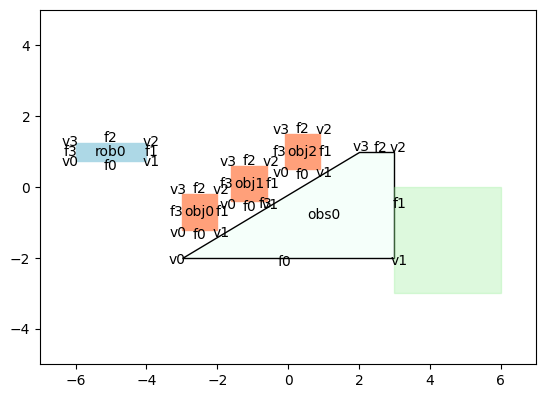

In [5]:
ws_x = 7
ws_y = 5
target_region_params = [
    ContactRegionParams(
        region_vertices=[[3, 0], [3, -3], [6, 0], [6, -3]], obj_indices=[0, 1, 2]
    ),
]
params = ContactGraphGeneratorParams(
    name="cg_stackpush_a2",
    obs_vertices=[[[-3, -2], [2, 1], [3, 1], [3, -2]]],
    obj_vertices=[
        [[1, 0.5], [1, -0.5], [2, -0.5], [2, 0.5]],
        [[1, 0.5], [1, -0.5], [2, -0.5], [2, 0.5]],
        [[1, 0.5], [1, -0.5], [2, -0.5], [2, 0.5]],
    ],
    rob_vertices=[[[0, 0], [0, 0.5], [2, 0], [2, 0.5]]],
    source_obj_pos=[[-2.5, -0.7], [-1.1, 0.1], [0.4, 1]],
    source_rob_pos=[[-5, 1]],
    target_region_params=target_region_params,
    n_pos_per_set=2,
    workspace=[[-ws_x, ws_x], [-ws_y, ws_y]],
)

generator = ContactGraphGenerator(params)
generator.plot()

In [ ]:
generator.generate_incremental_contact_graph()
cg_inc = IncrementalContactGraph.load_from_file(params.inc_graph_file_path)

## Stackpush a3 (5 objects)

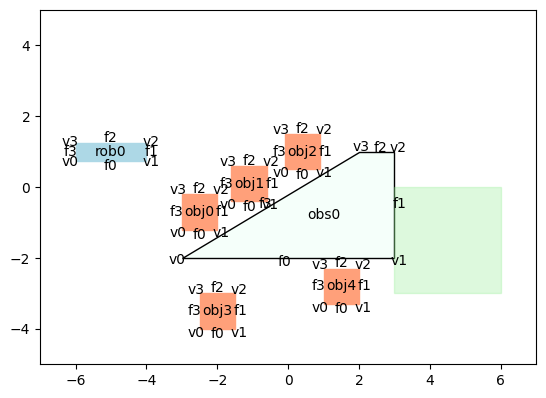

In [7]:
ws_x = 7
ws_y = 5
target_region_params = [
    ContactRegionParams(
        region_vertices=[[3, 0], [3, -3], [6, 0], [6, -3]], obj_indices=[0, 1, 2, 3, 4]
    ),
]
params = ContactGraphGeneratorParams(
    name="cg_stackpush_a3",
    obs_vertices=[[[-3, -2], [2, 1], [3, 1], [3, -2]]],
    obj_vertices=[
        [[1, 0.5], [1, -0.5], [2, -0.5], [2, 0.5]],
        [[1, 0.5], [1, -0.5], [2, -0.5], [2, 0.5]],
        [[1, 0.5], [1, -0.5], [2, -0.5], [2, 0.5]],
        [[1, 0.5], [1, -0.5], [2, -0.5], [2, 0.5]],
        [[1, 0.5], [1, -0.5], [2, -0.5], [2, 0.5]],
    ],
    rob_vertices=[[[0, 0], [0, 0.5], [2, 0], [2, 0.5]]],
    source_obj_pos=[[-2.5, -0.7], [-1.1, 0.1], [0.4, 1], [-2, -3.5], [1.5, -2.8]],
    source_rob_pos=[[-5, 1]],
    target_region_params=target_region_params,
    n_pos_per_set=2,
    workspace=[[-ws_x, ws_x], [-ws_y, ws_y]],
)

generator = ContactGraphGenerator(params)
generator.plot()

In [8]:
generator.generate_incremental_contact_graph()
cg_inc = IncrementalContactGraph.load_from_file(params.inc_graph_file_path)

INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 2/2 [00:00<00:00, 10754.63it/s]
INFO:large_gcs.graph.graph:Adding 2 vertices to graph...
100%|██████████| 2/2 [00:00<00:00, 4673.32it/s]
INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 21 body pairs...
100%|██████████| 21/21 [00:00<00:00, 55.71it/s]
INFO:large_gcs.graph.incremental_contact_graph:Calculating adjacent contact pair modes (606)
100%|██████████| 606/606 [00:03<00:00, 200.60it/s]

Set parameter UsernameSet parameter Username
Set parameter Username
Set parameter Username

Set parameter Username
Set parameter Username
Set parameter Username
Set parameter Username
Set parameter Username
Set parameter Username
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-04
Academic license - for non-commercial use only - expires 2024-03-04
Academic license - for non-commercial use only - expires 2024-03-04
Academic license - for non-commercial use only - expires 2024-03-04
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-04
Academic license - for non-commercial use only - expires 2024-03-04
Academic license - for non-commercial use only - expires 2024-03-04
Academic license - for non-commercial use only - expires 2024-03-04
Academic license - for non-commercial use only - expires 2024-03-04
Academic license - for non-commercial use only - expires 2024-03-04
Academic license - for non-commercial use on


INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 2/2 [00:00<00:00, 8802.32it/s]
INFO:large_gcs.graph.graph:Adding 2 vertices to graph...
100%|██████████| 2/2 [00:00<00:00, 17586.18it/s]
INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 21 body pairs...
100%|██████████| 21/21 [00:00<00:00, 59.36it/s]
INFO:large_gcs.graph.incremental_contact_graph:Calculating adjacent contact pair modes (606)
100%|██████████| 606/606 [00:03<00:00, 184.81it/s]

Set parameter Username
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-04
Academic license - for non-commercial use only - expires 2024-03-04
Set parameter Username
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-04
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-04
Academic license - for non-commercial use only - expires 2024-03-04
Set parameter Username
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-04
Academic license - for non-commercial use only - expires 2024-03-04
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-04
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-04
Set parameter Username
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-04
Academic license - for non-commercial use only - expires 2024-03-04

## Stackpush a4 (9 objects)

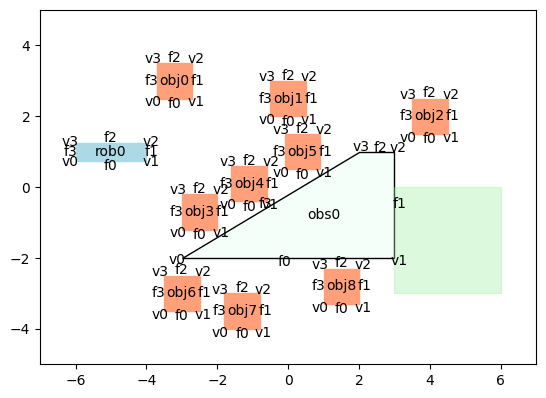

In [10]:
ws_x = 7
ws_y = 5
target_region_params = [
    ContactRegionParams(
        region_vertices=[[3, 0], [3, -3], [6, 0], [6, -3]], obj_indices=[0, 1, 2, 3, 4]
    ),
]
params = ContactGraphGeneratorParams(
    name="cg_stackpush_a4",
    obs_vertices=[[[-3, -2], [2, 1], [3, 1], [3, -2]]],
    obj_vertices=[
        [[1, 0.5], [1, -0.5], [2, -0.5], [2, 0.5]],
        [[1, 0.5], [1, -0.5], [2, -0.5], [2, 0.5]],
        [[1, 0.5], [1, -0.5], [2, -0.5], [2, 0.5]],
        [[1, 0.5], [1, -0.5], [2, -0.5], [2, 0.5]],
        [[1, 0.5], [1, -0.5], [2, -0.5], [2, 0.5]],
        [[1, 0.5], [1, -0.5], [2, -0.5], [2, 0.5]],
        [[1, 0.5], [1, -0.5], [2, -0.5], [2, 0.5]],
        [[1, 0.5], [1, -0.5], [2, -0.5], [2, 0.5]],
        [[1, 0.5], [1, -0.5], [2, -0.5], [2, 0.5]],
    ],
    rob_vertices=[[[0, 0], [0, 0.5], [2, 0], [2, 0.5]]],
    source_obj_pos=[
        [-3.2, 3], [0,2.5], [4, 2],
        [-2.5, -0.7], [-1.1, 0.1], [0.4, 1],
        [-3,-3], [-1.3, -3.5], [1.5, -2.8]],
    source_rob_pos=[[-5, 1]],
    target_region_params=target_region_params,
    n_pos_per_set=2,
    workspace=[[-ws_x, ws_x], [-ws_y, ws_y]],
)

generator = ContactGraphGenerator(params)
generator.plot()

In [11]:
generator.generate_incremental_contact_graph()
cg_inc = IncrementalContactGraph.load_from_file(params.inc_graph_file_path)

INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 2/2 [00:00<00:00, 33825.03it/s]
INFO:large_gcs.graph.graph:Adding 2 vertices to graph...
100%|██████████| 2/2 [00:00<00:00, 6393.76it/s]
INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 55 body pairs...
  0%|          | 0/55 [00:00<?, ?it/s]

100%|██████████| 55/55 [00:01<00:00, 54.50it/s]
INFO:large_gcs.graph.incremental_contact_graph:Calculating adjacent contact pair modes (1590)
100%|██████████| 1590/1590 [00:03<00:00, 505.68it/s]

Set parameter Username
Set parameter Username
Set parameter Username
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-04
Academic license - for non-commercial use only - expires 2024-03-04
Academic license - for non-commercial use only - expires 2024-03-04
Academic license - for non-commercial use only - expires 2024-03-04
Set parameter Username
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-04
Academic license - for non-commercial use only - expires 2024-03-04
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-04
Set parameter Username
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-04
Academic license - for non-commercial use only - expires 2024-03-04
Set parameter Username
Set parameter Username
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-04
Academic license - for non-commercial use on


INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 2/2 [00:00<00:00, 15857.48it/s]
INFO:large_gcs.graph.graph:Adding 2 vertices to graph...
100%|██████████| 2/2 [00:00<00:00, 20020.54it/s]
INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 55 body pairs...
100%|██████████| 55/55 [00:01<00:00, 54.26it/s]
INFO:large_gcs.graph.incremental_contact_graph:Calculating adjacent contact pair modes (1590)
  1%|          | 8/1590 [00:03<08:15,  3.20it/s]  

Set parameter Username
Set parameter Username
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-04
Academic license - for non-commercial use only - expires 2024-03-04
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-04
Set parameter Username
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-04
Academic license - for non-commercial use only - expires 2024-03-04
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-04
Academic license - for non-commercial use only - expires 2024-03-04
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-04
Set parameter Username
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-04
Academic license - for non-commercial use only - expires 2024-03-04
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-04

100%|██████████| 1590/1590 [00:03<00:00, 453.87it/s]


Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-04


# Radial Sort

## Radial Sort a1

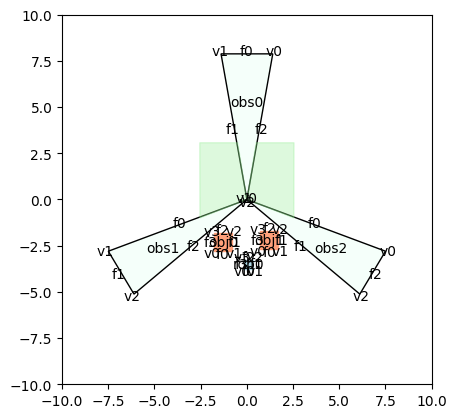

In [38]:
ws_x = 10
ws_y = 10
target_region_params = [
    ContactRegionParams(
        region_vertices=[[0,0], [2.54, -1], [2.55, 3.07], [0.5, 3.07]], obj_indices=[0]
    ),
    ContactRegionParams(
        region_vertices=[[0,0], [-2.54, -1], [-2.55, 3.07], [-0.5, 3.07]], obj_indices=[1]
    ),
]
box_obj_verts = [[1, 0.5], [1, -0.5], [2, -0.5], [2, 0.5]]
params = ContactGraphGeneratorParams(
    name="cg_radialsort_a1",
    obs_vertices=[[[0, 0], [1.4, 7.88], [-1.4, 7.88]],
                  [[0, 0], [-7.5, -2.8], [-6.11, -5.12]],
                  [[0, 0], [7.5, -2.8], [6.11, -5.12]]],
    obj_vertices=[box_obj_verts] * 2,
    rob_vertices=[[[0, 0], [0, 0.5], [0.5, 0], [0.5, 0.5]]],
    source_obj_pos=[
        [-1.3, -2.3], [1.2, -2.2],
    ],
    source_rob_pos=[[0.1, -3.5]],
    target_region_params=target_region_params,
    n_pos_per_set=2,
    workspace=[[-ws_x, ws_x], [-ws_y, ws_y]],
)

generator = ContactGraphGenerator(params)
generator.plot()

In [39]:
generator.generate_incremental_contact_graph()

INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 2/2 [00:00<00:00, 6825.56it/s]
INFO:large_gcs.graph.graph:Adding 2 vertices to graph...
100%|██████████| 2/2 [00:00<00:00, 11491.24it/s]


INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 12 body pairs...
100%|██████████| 12/12 [00:00<00:00, 51.15it/s]
INFO:large_gcs.graph.incremental_contact_graph:Calculating adjacent contact pair modes (345)
100%|██████████| 345/345 [00:02<00:00, 118.40it/s]

Set parameter Username
Set parameter Username
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-04
Academic license - for non-commercial use only - expires 2024-03-04
Academic license - for non-commercial use only - expires 2024-03-04
Set parameter Username
Set parameter Username
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-04Academic license - for non-commercial use only - expires 2024-03-04

Academic license - for non-commercial use only - expires 2024-03-04
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-04
Set parameter Username
Set parameter Username
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-04
Academic license - for non-commercial use only - expires 2024-03-04
Academic license - for non-commercial use only - expires 2024-03-04
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-04

## Radial Sort a2

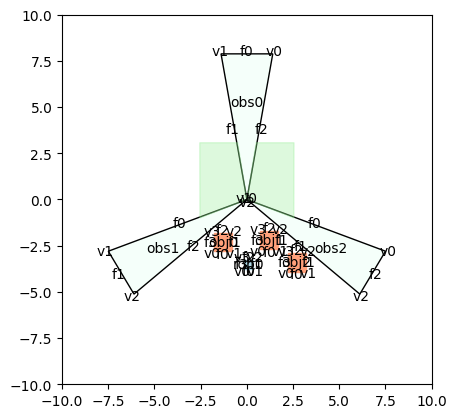

In [47]:
ws_x = 10
ws_y = 10
target_region_params = [
    # Right
    ContactRegionParams(
        region_vertices=[[0,0], [2.54, -1], [2.55, 3.07], [0.5, 3.07]], obj_indices=[0,2]
    ),
    # Left
    ContactRegionParams(
        region_vertices=[[0,0], [-2.54, -1], [-2.55, 3.07], [-0.5, 3.07]], obj_indices=[1]
    ),
]
box_obj_verts = [[1, 0.5], [1, -0.5], [2, -0.5], [2, 0.5]]
params = ContactGraphGeneratorParams(
    name="cg_radialsort_a2",
    obs_vertices=[[[0, 0], [1.4, 7.88], [-1.4, 7.88]],
                  [[0, 0], [-7.5, -2.8], [-6.11, -5.12]],
                  [[0, 0], [7.5, -2.8], [6.11, -5.12]]],
    obj_vertices=[box_obj_verts] * 3,
    rob_vertices=[[[0, 0], [0, 0.5], [0.5, 0], [0.5, 0.5]]],
    source_obj_pos=[
        [-1.3, -2.3], [1.2, -2.2], [2.7, -3.4]
    ],
    source_rob_pos=[[0.1, -3.5]],
    target_region_params=target_region_params,
    n_pos_per_set=2,
    workspace=[[-ws_x, ws_x], [-ws_y, ws_y]],
)

generator = ContactGraphGenerator(params)
generator.plot()

In [48]:
generator.generate_incremental_contact_graph()

INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 2/2 [00:00<00:00, 37117.73it/s]
INFO:large_gcs.graph.graph:Adding 2 vertices to graph...
100%|██████████| 2/2 [00:00<00:00, 12354.36it/s]
INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 18 body pairs...


100%|██████████| 18/18 [00:00<00:00, 56.72it/s]
INFO:large_gcs.graph.incremental_contact_graph:Calculating adjacent contact pair modes (555)
100%|██████████| 555/555 [00:02<00:00, 201.07it/s]

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-04
Set parameter Username
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-04
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-04
Academic license - for non-commercial use only - expires 2024-03-04
Set parameter Username
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-04
Academic license - for non-commercial use only - expires 2024-03-04
Set parameter Username
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-04
Academic license - for non-commercial use only - expires 2024-03-04
Set parameter Username
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-04
Academic license - for non-commercial use only - expires 2024-03-04
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-04